In [20]:
options(warn=-1)
suppressPackageStartupMessages(library(SingleCellExperiment))
suppressPackageStartupMessages(library(SummarizedExperiment))
suppressPackageStartupMessages(library(variancePartition))
suppressPackageStartupMessages(library(limma))
suppressPackageStartupMessages(library(edgeR))
suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(scater))
suppressPackageStartupMessages(library(glmmSeq))
suppressPackageStartupMessages(library(lmerTest))
suppressPackageStartupMessages(library(pbmcapply))
# suppressPackageStartupMessages(library(optparse))

In [21]:
# read in the sce object
setwd('/lustre/scratch117/cellgen/team297/kt16/COVID_imperial_renal/')
source('scripts/glmm_functions.R')
sce <- readRDS('h5ad/df.fil3_gex_bcells_vdj_sce_B_mem_all.RDS')
sce

class: SingleCellExperiment 
dim: 32913 15093 
metadata(10): WHO_temp_severity_colors case_control_colors ...
  initial_cluster_B_colors seurat_clusters_colors
assays(2): X counts
rownames(32913): MIR1302-2HG FAM138A ... AC213203.1 FAM231C
rowData names(6): vst.mean vst.variance ... vst.variable GEX
colnames(15093): UK-CIC10689738+UK-CIC10690026_AACCATGCAGTCACTA-1
  UK-CIC10689738+UK-CIC10690026_AACCGCGAGTCTCCTC-1 ...
  UK-CIC10690384+UK-CIC10690576_TTTACTGAGGTGGGTT-1
  UK-CIC10690384+UK-CIC10690576_TTTATGCTCCTCAATT-1
colData names(67): orig.ident nCount_RNA ... time_from_positive_swab
  time_from_infection
reducedDimNames(5): X_harmony_rna X_pca_rna UMAP X_umapafterharmony_rna
  X_umapbeforeharmony_rna
altExpNames(0):

In [22]:
counts(sce) <- assays(sce)[['X']] # because i'm saving from a h5ad object with anndata2ri
sce$case_control <- factor(sce$case_control, levels = c('NEGATIVE', 'POSITIVE', 'RECOVERY'))
sce$WHO_temp_severity <- factor(sce$WHO_temp_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'))
sce$WHO_severity_group <- factor(sce$WHO_temp_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'), labels = c('NA', 'mild_moderate', 'mild_moderate', 'severe_critical', 'severe_critical'))
sce$grouped_severity <- ifelse(sce$WHO_temp_severity %in% c("mild", "moderate"), "mild_moderate", "severe_critical")
sce$age_scaled <- scale(sce$calc_age) # scale age

In [16]:
# counts(sce) <- assays(sce)[['X']] # because i'm saving from a h5ad object with anndata2ri
# sce$case_control <- factor(sce$case_control, levels = c('NEGATIVE', 'POSITIVE', 'RECOVERY'))
# sce$WHO_temp_severity <- factor(sce$WHO_temp_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'))
# sce$WHO_severity_group <- factor(sce$WHO_temp_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'), labels = c('NA', 'mild_moderate', 'mild_moderate', 'severe_critical', 'severe_critical'))
# sce$grouped_severity <- ifelse(sce$WHO_temp_severity %in% c("mild"), "mild", "moderate_severe_critical")
# sce$age_scaled <- scale(sce$calc_age) # scale age

In [23]:
min_cells = 10
ncpus = 10

In [24]:
# Comparison 1: deg from ordered WHO temp severity Remove samples with less than MIN
nCells <- table(sce$sample_id)
rmSamples <- names(nCells[nCells < min_cells])
sce1 <- sce[, !sce$sample_id %in% rmSamples]
# drop unused levels
sce1$individual_id <- droplevels(sce1$individual_id)
sce1$sample_id <- droplevels(sce1$sample_id)
sce1$case_control <- droplevels(sce1$case_control)
sce1$ethnicity <- droplevels(sce1$ethnicity)
sce1$sex <- droplevels(sce1$sex)
# Summarize Counts
smrzd <- aggregateAcrossCells(sce1, id = as.character(colData(sce1)[, c("sample_id")]))
y <- DGEList(counts = counts(smrzd), samples = colData(smrzd))
y <- setupDGElist(y, "WHO_severity_group", ordered = TRUE, remove = "NA") # use grouped_severity later

In [25]:
res1 <- testDGElist(y,
            formula = as.formula("~ grouped_severity + sex + ethnicity + age_scaled + centre + (1|individual_id)"),
            individual_id = "individual_id",
            ncores = ncpus)


n = 138 samples, 37 individuals
Time difference of 3.5525 mins


In [26]:
res1 <- glmmQvals(res1, pi0=1)


q_grouped_severity
------------------
Not Significant     Significant 
           7050             485 

q_sex
-----
Not Significant     Significant 
           7058             477 

q_ethnicity
-----------
Not Significant     Significant 
           6877             658 

q_age_scaled
------------
Not Significant     Significant 
           7033             502 

q_centre
--------
Not Significant     Significant 
             50            7485 


In [10]:
# Comparison 1: deg from ordered WHO temp severity
# Remove samples with less than MIN
nCells <- table(sce$sample_id)
rmSamples <- names(nCells[nCells<5])
sce1 <- sce[,!sce$sample_id %in% rmSamples]
# drop unused levels
sce1$individual_id <- droplevels(sce1$individual_id)
sce1$sample_id <- droplevels(sce1$sample_id)
sce1$case_control <- droplevels(sce1$case_control)
sce1$ethnicity <- droplevels(sce1$ethnicity)
sce1$sex <- droplevels(sce1$sex)
# Summarize Counts
smrzd <- aggregateAcrossCells(sce1, id=as.character(colData(sce1)[,c("sample_id")]))
y <- DGEList(counts=counts(smrzd), samples=colData(smrzd))
y <- setupDGElist(y, 'WHO_temp_severity', ordered = TRUE, remove = "NA")

In [6]:
res1a <- testDGElist(y, 
            formula = as.formula("~ WHO_temp_severity + sex + ethnicity + age_scaled + centre + (1|individual_id)"), 
            individual_id = 'individual_id',
            designMatrix = model.matrix(as.formula("~ WHO_temp_severity + sex + ethnicity + age_scaled + centre"), data=y$samples)
           )

In [7]:
res1b <- testDGElist(y, 
            formula = as.formula("~ WHO_temp_severity + sex + ethnicity + calc_age + centre + (1|individual_id)"), 
            individual_id = 'individual_id',
            designMatrix = model.matrix(as.formula("~ WHO_temp_severity + sex + ethnicity + calc_age + centre"), data=y$samples)
           )


n = 27 samples, 19 individuals
Time difference of 17.13443 mins
Errors in 17 gene(s):CD52, TENT5C, RPL37A, IRF4, HIST1H3G, GLCCI1, AHNAK, RNF213, LINC01480, MT-CO1, MT-CO2, MT-ATP8, MT-ATP6, MT-CO3, MT-ND4L, MT-ND4, MT-ND6

In [11]:
res1c <- testDGElist(y, 
            formula = as.formula("~ WHO_temp_severity + sex + ethnicity + age_centered + centre + (1|individual_id)"), 
            individual_id = 'individual_id',
            designMatrix = model.matrix(as.formula("~ WHO_temp_severity + sex + ethnicity + age_centered + centre"), data=y$samples)
           )


n = 27 samples, 19 individuals
Time difference of 10.68638 mins
Errors in 17 gene(s):CD52, TENT5C, RPL37A, IRF4, HIST1H3G, GLCCI1, AHNAK, RNF213, LINC01480, MT-CO1, MT-CO2, MT-ATP8, MT-ATP6, MT-CO3, MT-ND4L, MT-ND4, MT-ND6

In [8]:
res1b <- glmmQvals(res1b, pi0=1)


q_WHO_temp_severity
-------------------
Not Significant     Significant 
            212            4272 

q_sex
-----
Not Significant     Significant 
           4073             411 

q_ethnicity
-----------
Not Significant     Significant 
           3650             834 

q_calc_age
----------
Not Significant     Significant 
           4156             328 

q_centre
--------
Not Significant     Significant 
            744            3740 


In [13]:
res1d <- testDGElist(y, 
            formula = as.formula("~ WHO_temp_severity + sex + ethnicity + age_centered + (1|individual_id)"), 
            individual_id = 'individual_id',
            designMatrix = model.matrix(as.formula("~ WHO_temp_severity + sex + ethnicity + age_centered "), data=y$samples)
           )


n = 27 samples, 19 individuals
Time difference of 10.22492 mins
Errors in 7 gene(s):GLCCI1, ITGB1, CCL3, UPF1, LINC01480, MT-ND4, MT-ND5

In [12]:
res1c <- glmmQvals(res1c, pi0=1)


q_WHO_temp_severity
-------------------
Not Significant     Significant 
            195            4289 

q_sex
-----
Not Significant     Significant 
           3784             700 

q_ethnicity
-----------
Not Significant     Significant 
           3279            1205 

q_age_centered
--------------
Not Significant     Significant 
           4361             123 

q_centre
--------
Not Significant     Significant 
            688            3796 


In [14]:
res1d <- glmmQvals(res1d, pi0=1)


q_WHO_temp_severity
-------------------
Not Significant     Significant 
            169            4325 

q_sex
-----
Not Significant     Significant 
           3800             694 

q_ethnicity
-----------
Not Significant     Significant 
           3694             800 

q_age_centered
--------------
Not Significant     Significant 
           4422              72 


In [75]:
ordered_contrast = 'WHO_temp_severity'
results1 <- res1@stats
ordered_contrasts = c(paste0(ordered_contrast, c('.L', '.Q')),paste0(c('P_', 'q_'), ordered_contrast))
results1 <- results1[,colnames(results1) %in% ordered_contrasts]

In [76]:
# Comparison 2: deg from ordered WHO temp severity
# Remove samples with less than MIN
nCells <- table(sce$sample_id)
rmSamples <- names(nCells[nCells<5])
sce1 <- sce[,!sce$sample_id %in% rmSamples]
# drop unused levels
sce1$individual_id <- droplevels(sce1$individual_id)
sce1$sample_id <- droplevels(sce1$sample_id)
sce1$case_control <- droplevels(sce1$case_control)
sce1$ethnicity <- droplevels(sce1$ethnicity)
sce1$sex <- droplevels(sce1$sex)
# Summarize Counts
smrzd <- aggregateAcrossCells(sce1, id=as.character(colData(sce1)[,c("sample_id")]))
y <- DGEList(counts=counts(smrzd), samples=colData(smrzd))
y <- setupDGElist(y, 'WHO_severity_group', ordered = TRUE, remove = "NA")
y$samples$grouped_severity <- ifelse(y$samples$WHO_severity %in% c("mild", "moderate"), "mild_moderate", "severe_critical")

In [43]:
#     reducedVars <- rownames(attr(terms(reducedFormula), "factors"))
#     varLevels <- lapply(reducedVars, function(x) {
#       if (is.factor(metadata[, x])) {
#         return(levels(subsetMetadata[, x]))
#       } else {sort(unique(subsetMetadata[, x]))}
#     })
#     modelData <- expand.grid(varLevels)
#     colnames(modelData) <- reducedVars

In [98]:
modelFormula <- as.formula("~ splines::bs(days_to_sampling, degree = 2) * grouped_severity + sex + ethnicity + age_scaled + centre + (1|individual_id)")
modelFormula

~splines::bs(days_to_sampling, degree = 2) * grouped_severity + 
    sex + ethnicity + age_scaled + centre + (1 | individual_id)

In [103]:
nonRandomFormula <- subbars(modelFormula)
nonRandomFormula

~splines::bs(days_to_sampling, degree = 2) * grouped_severity + 
    sex + ethnicity + age_scaled + centre + (1 + individual_id)

In [93]:
library(pbmcapply)
glmmSeq_interaction <- function(modelFormula,
                    countdata,
                    metadata,
                    id,
                    dispersion,
                    sizeFactors = NULL,
                    reducedFormula = "",
                    modelData = NULL,
                    designMatrix = NULL,
                    control = glmerControl(optimizer = "bobyqa"),
                    cores = 1,
                    zeroCount = 0.125,
                    verbose = TRUE,
                    returnList = FALSE, 
                    progress = TRUE,
                    ...) {
  
  # Catch errors
  if (length(findbars(modelFormula)) == 0) {
    stop("No random effects terms specified in formula")
  }
  if (ncol(countdata) != nrow(metadata)) {
    stop("countdata columns different size to metadata rows")
  }
  if (!is.null(sizeFactors) & ncol(countdata) != length(sizeFactors)) {
    stop("Different sizeFactors length")
  }
  if (! is.numeric(zeroCount)) stop("zeroCount must be numeric")
  if (zeroCount < 0) stop("zeroCount must be > = 0")
  if (zeroCount > 0) countdata[countdata == 0] <- zeroCount
  
  # Manipulate formulae
  fullFormula <- update.formula(modelFormula, count ~ ., simplify = FALSE)
  nonRandomFormula <- subbars(modelFormula)
  variables <- rownames(attr(terms(nonRandomFormula), "factors"))
  ids <- as.character(metadata[, id])
  
  # Check numbers and alignment
  if (! all(rownames(countdata) %in% names(dispersion), nrow(countdata))) {
    stop("Dispersion length must match nrow in countdata")
  }
  
  if (!is.null(sizeFactors)) offset <- log(sizeFactors) else offset <- NULL
  if (verbose) cat(paste0("\nn = ", length(ids), " samples, ", length(unique(ids)), " individuals\n"))
  
  # setup model prediction
  if (reducedFormula == "") reducedFormula <- nobars(modelFormula)
  
  if (is.null(designMatrix)){
    designMatrix <- model.matrix(reducedFormula, modelData)
  } 
  
  start <- Sys.time()
  fullList <- lapply(rownames(countdata), function(i) {
    list(y = countdata[i, ], dispersion = dispersion[i])
  })
  
  # For each gene perform a fit
  if (progress) {
      resultList <- pbmclapply(fullList, function(geneList) {
        glmerApply_interaction(geneList, fullFormula = fullFormula, data = metadata,
                   control = control, offset = offset,
                    ...)
      }, mc.cores = cores)
      if ("value" %in% names(resultList)) resultList <- resultList$value
    } else {
      resultList <- mclapply(fullList, function(geneList) {
        glmerApply_interaction(geneList, fullFormula = fullFormula, data = metadata,
                   control = control, offset = offset,
                    ...)
      }, mc.cores = cores)
    }
  if(returnList) return(resultList)
  
  # Print timing if verbose
  end <- Sys.time()
  if (verbose) print(end - start)
  
  # Output
  names(resultList) <- rownames(countdata)
  noErr <- vapply(resultList, function(x) x$tryErrors == "", FUN.VALUE = TRUE)
  if (length(which(noErr)) == 0) { 
    stop("All genes returned an error. Check sufficient data in each group")
  }
    
  if (sum(!noErr) != 0) {
    if (verbose) cat(paste0("Errors in ", sum(!noErr), " gene(s):",
                            paste0(names(noErr)[! noErr], collapse = ", ")))
    outputErrors <- vapply(resultList[!noErr], function(x) {x$tryErrors},
                           FUN.VALUE = c("test"))
  } else {outputErrors <- c("No errors")}
  
  optInfo <- t(vapply(resultList[noErr], function(x) {
    setNames(x$optinfo, c("Singular", "Conv"))
  }, FUN.VALUE = c(1, 1)))
  
  nCheat <- resultList[noErr][[1]]$stats
  s <- t(vapply(resultList[noErr], function(x) {x$stats}, FUN.VALUE = rep(1, length(nCheat))))
  f <- t(vapply(resultList[noErr], function(x) {x$fit}, FUN.VALUE = rep(1, length(nCheat))))
  
  # Create GlmmSeq object with results
  new("GlmmSeq",
      formula = fullFormula,
      stats = s,
      fit = f,
      reducedFormula = reducedFormula,
      countdata = countdata,
      metadata = subsetMetadata,
      optInfo = optInfo,
      errors = outputErrors,
      variables = id
  )
}

glmerApply_interaction <- function(geneList,
                       fullFormula,
                       data,
                       control,
                       offset,
                       ...) {
  data[, "count"] <- as.numeric(geneList$y)
  fit <- try(suppressMessages(suppressWarnings(
    lme4::glmer(fullFormula, data = data, control = control, offset = offset, family = MASS::negative.binomial(theta = 1/geneList$dispersion)), ...)), silent = TRUE)
  
  if (class(fit) != "try-error") {
    # intercept dropped genes
    if (length(attr(fit@pp$X, "msgRankdrop")) > 0)  {
      return( list(stats = NA, predict = NA, optinfo = NA,
                   tryErrors = attr(fit@pp$X, "msgRankdrop")) )
    }
    stats <- setNames(c(geneList$dispersion, AIC(fit),
                        as.numeric(logLik(fit))),
                      c("Dispersion", "AIC", "logLik"))
    fixedEffects <- fixef(fit)
    wald <- car::Anova(fit)
    waldtest <- setNames(c(wald[, "Chisq"], wald[, "Pr(>Chisq)"]),
                         c(paste0("Chisq_", rownames(wald)),
                           paste0("P_", rownames(wald))))
    singular <- as.numeric(isSingular(fit))
    conv <- length(slot(fit, "optinfo")$conv$lme4$messages)
    # rm(fit, data)
    return(list(stats = c(stats, fixedEffects, waldtest),
                fit = fit,
                optinfo = c(singular, conv),
                tryErrors = "") )
  } else {
    return(list(stats = NA, predict = NA, optinfo = NA, tryErrors = fit[1]))
  }
}

testDGElist_interaction <- function(dgelist, formula, individual_id, designMatrix = NULL, ncores = NULL) {
    if (is.null(ncores)){
        NCORES <- parallel::detectCores()-1
    } else {
        NCORES <- ncores
    }
    # Estimate Dispersion
    disp  <- suppressMessages(setNames(edgeR::estimateDisp(dgelist)$tagwise.dispersion, rownames(dgelist)))
    # Norm
    sizeFactors <- calcNormFactors(dgelist$counts)
    results <- glmmSeq_interaction(formula,
                id = individual_id,
                countdata = dgelist$counts,
                metadata = dgelist$samples,
                dispersion = disp,
                sizeFactors = sizeFactors,
                removeDuplicatedMeasures = FALSE,
                designMatrix = designMatrix,
                removeSingles = FALSE,
                progress = TRUE, cores = NCORES)
    return(results)
}

In [107]:
glmm_interaction <- function(dgeList,
                             modelFormula,
                             id,
                             control = glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)),
                             cores = 1,
                             verbose = TRUE, ...){
  require(pbmcapply)
  require(lmerTest)
  metadata <- dgeList$samples
  countdata <- dgeList$counts
  dispersion <- suppressMessages(setNames(edgeR::estimateDisp(dgeList)$tagwise.dispersion, rownames(dgeList)))
  sizeFactors <- calcNormFactors(dgeList$counts)

  # Manipulate formulae
  reducedFormula <- nobars(modelFormula)
  designMatrix <- model.matrix(reducedFormula, data=dgeList$samples)
  fullFormula <- update.formula(modelFormula, count ~ ., simplify = FALSE)
  nonRandomFormula <- subbars(modelFormula)
  variables <- rownames(attr(terms(nonRandomFormula), "factors"))
  ids <- as.character(metadata[, id])
  # Check numbers and alignment
  if (! all(rownames(countdata) %in% names(dispersion), nrow(countdata))) {
    stop("Dispersion length must match nrow in countdata")
  }

  if (!is.null(sizeFactors)) offset <- log(sizeFactors) else offset <- NULL
  if (verbose) cat(paste0("\nn = ", length(ids), " samples, ", length(unique(ids)), " individuals\n"))

  start <- Sys.time()
  fullList <- lapply(rownames(countdata), function(i) {
    list(y = countdata[i, ], dispersion = dispersion[i])
  })

  resultList <- pbmclapply(fullList, function(geneList) {
    run_glmm(geneList, fullFormula = fullFormula, data = metadata, control = control, offset = offset, ...)
  }, mc.cores = cores)

  # Print timing if verbose
  end <- Sys.time()
  if (verbose) print(end - start)

  # Output
  names(resultList) <- rownames(countdata)
  noErr <- vapply(resultList, function(x) x$tryErrors == "", FUN.VALUE = TRUE)
  if (length(which(noErr)) == 0) { 
    stop("All genes returned an error. Check sufficient data in each group")
  }
    
  if (sum(!noErr) != 0) {
    if (verbose) cat(paste0("Errors in ", sum(!noErr), " gene(s):",
                            paste0(names(noErr)[! noErr], collapse = ", ")))
    outputErrors <- vapply(resultList[!noErr], function(x) {x$tryErrors},
                           FUN.VALUE = c("test"))
  } else {outputErrors <- c("No errors")}
  
  optInfo <- t(vapply(resultList[noErr], function(x) {
    setNames(x$optinfo, c("Singular", "Conv"))
  }, FUN.VALUE = c(1, 1)))
  
  nCheat <- resultList[noErr][[1]]$stats
  s <- t(vapply(resultList[noErr], function(x) {x$stats}, FUN.VALUE = rep(1, length(nCheat))))
  f <- t(vapply(resultList[noErr], function(x) {x$fit}, FUN.VALUE = rep(1, length(nCheat))))

  return(resultList)
}

run_glmm <- function(data, geneList, fullFormula, control, offset, ...){
  data[, "count"] <- as.numeric(geneList$y)
  fit <- lme4::glmer(fullFormula,
                     data = data,
                     control = control,
                     offset = offset,
                     family = MASS::negative.binomial(theta = 1/fullList[[1]]$dispersion),
                     ...)
  if (class(fit) != "try-error") {
    stats <- setNames(c(geneList$dispersion, AIC(fit), as.numeric(logLik(fit))), c("Dispersion", "AIC", "logLik"))
    fixedEffects <- fixef(fit)
    wald <- car::Anova(fit)
    waldtest <- setNames(c(wald[, "Chisq"], wald[, "Pr(>Chisq)"]),
                         c(paste0("Chisq_", rownames(wald)),
                           paste0("P_", rownames(wald))))
    singular <- as.numeric(isSingular(fit))
    conv <- length(slot(fit, "optinfo")$conv$lme4$messages)
    return(list(stats = c(stats, fixedEffects, waldtest),
                fit = fit,
                optinfo = c(singular, conv),
                tryErrors = "") )
  } else {
   return(list(stats = NA, predict = NA, optinfo = NA, tryErrors = fit[1]))
  }

}

In [108]:
# Comparison 2: deg from the interaction between WHO temp severity groups and time
res2 <- glmm_interaction(y, 
            modelFormula = as.formula("~ splines::bs(days_to_sampling, degree = 2) * grouped_severity + sex + ethnicity + calc_age + centre + (1|individual_id)"), 
            id = 'individual_id')

In [45]:
  verbose = TRUE
  modelFormula <- as.formula("~ splines::bs(days_to_sampling, degree = 2) * grouped_severity + sex + ethnicity + age_scaled + centre + (1|individual_id)")
  reducedFormula <- nobars(modelFormula)
  metadata <- y$samples
  id <- 'individual_id'
  countdata <- y$counts
  dispersion <- suppressMessages(setNames(edgeR::estimateDisp(y)$tagwise.dispersion, rownames(y)))
  sizeFactors <- calcNormFactors(y$counts)
  designMatrix <- model.matrix(as.formula("~ splines::bs(days_to_sampling, degree = 2) * grouped_severity + sex + ethnicity + age_scaled + centre"), data=y$samples)
  # Manipulate formulae
  fullFormula <- update.formula(modelFormula, count ~ ., simplify = FALSE)
  nonRandomFormula <- subbars(modelFormula)
  variables <- rownames(attr(terms(nonRandomFormula), "factors"))
  ids <- as.character(metadata[, id])
  
  # Check numbers and alignment
  if (! all(rownames(countdata) %in% names(dispersion), nrow(countdata))) {
    stop("Dispersion length must match nrow in countdata")
  }
  
  if (!is.null(sizeFactors)) offset <- log(sizeFactors) else offset <- NULL
  if (verbose) cat(paste0("\nn = ", length(ids), " samples, ", length(unique(ids)), " individuals\n"))
  
  # setup model prediction
  if (reducedFormula == "") reducedFormula <- nobars(modelFormula)
  
  if (is.null(designMatrix)){
    designMatrix <- model.matrix(reducedFormula, modelData)
  } 
  
  start <- Sys.time()
  fullList <- lapply(rownames(countdata), function(i) {
    list(y = countdata[i, ], dispersion = dispersion[i])
  })


n = 27 samples, 19 individuals


In [96]:
resultList <- pbmclapply(fullList, function(geneList) {
    glmerApply_interaction(geneList, fullFormula = fullFormula, data = metadata, control = control, offset = offset)    
},mc.cores = 32)

In [95]:
resultList[[1]]

[1] "Error in solve.default(L %*% V %*% t(L)) : \n  system is computationally singular: reciprocal condition number = 6.00415e-17\n"
attr(,"class")
[1] "try-error"
attr(,"condition")
<simpleError in solve.default(L %*% V %*% t(L)): system is computationally singular: reciprocal condition number = 6.00415e-17>

In [45]:
# library(lmerTest)
# control = glmerControl(optimizer = "bobyqa", optCtrl=list(maxfun=100000))
# test <- glmerApply_interaction(fullList[[1]], fullFormula = fullFormula, data = metadata, control = control, offset = offset)

In [47]:
data <- metadata
data[, "count"] <- as.numeric(fullList[[1]]$y)

In [48]:
library(lmerTest)

control = glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5))
data <- metadata
data[, "count"] <- as.numeric(fullList[[1]]$y)
fit <- lme4::glmer(fullFormula, data = data, control = control, offset = offset, family = MASS::negative.binomial(theta = 1/fullList[[1]]$dispersion))

In [51]:
car::Anova(fit)

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
"splines::bs(days_to_sampling, degree = 2)",18.29843053,2,1.063032e-04
grouped_severity,0.91862478,1,3.378363e-01
sex,0.07713824,1,7.812137e-01
ethnicity,4.77870119,3,1.887377e-01
age_scaled,3.11336182,1,7.765253e-02
centre,3.18729702,1,7.421263e-02
"splines::bs(days_to_sampling, degree = 2):grouped_severity",38.76357385,2,3.824696e-09


In [63]:
colnames(res1@stats)

[1] "Dispersion"              "AIC"                    
 [3] "logLik"                  "(Intercept)"            
 [5] "WHO_temp_severity.L"     "WHO_temp_severity.Q"    
 [7] "WHO_temp_severity.C"     "sexM"                   
 [9] "ethnicityblack"          "ethnicityother"         
[11] "ethnicitywhite"          "age_scaled"             
[13] "centreNCL"               "Chisq_WHO_temp_severity"
[15] "Chisq_sex"               "Chisq_ethnicity"        
[17] "Chisq_age_scaled"        "Chisq_centre"           
[19] "P_WHO_temp_severity"     "P_sex"                  
[21] "P_ethnicity"             "P_age_scaled"           
[23] "P_centre"                "q_WHO_temp_severity"    
[25] "q_sex"                   "q_ethnicity"            
[27] "q_age_scaled"            "q_centre"

In [53]:
summaryfit <- summary(fit)
summaryfit

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Negative Binomial(29.248)  ( log )
Formula: 
count ~ splines::bs(days_to_sampling, degree = 2) + grouped_severity +  
    sex + ethnicity + age_scaled + centre + (1 | individual_id) +  
    splines::bs(days_to_sampling, degree = 2):grouped_severity
   Data: data
 Offset: offset
Control: control

     AIC      BIC   logLik deviance df.resid 
   190.5    208.6    -81.2    162.5       13 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.79119 -0.73883 -0.07322  0.60667  2.46539 

Random effects:
 Groups        Name        Variance Std.Dev.
 individual_id (Intercept) 0.6931   0.8325  
Number of obs: 27, groups:  individual_id, 19

Fixed effects:
                                                                           Estimate
(Intercept)                                                                -2.42417
splines::bs(days_to_sampling, degree = 2)1                 

In [56]:
summaryfit$coefficients

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),-2.42416692,1.7666255,-1.3722020,0.17000058
"splines::bs(days_to_sampling, degree = 2)1",2.92557616,2.6766122,1.0930146,0.27438740
"splines::bs(days_to_sampling, degree = 2)2",3.35528689,1.9061574,1.7602360,0.07836780
grouped_severitysevere_critical,-3.29374450,1.6107963,-2.0447927,0.04087530
sexM,0.24754455,0.8912889,0.2777377,0.78121370
ethnicityblack,1.82824790,1.3353814,1.3690830,0.17097334
ethnicityother,0.04564763,1.4890182,0.0306562,0.97554373
ethnicitywhite,1.60031861,0.8218516,1.9472111,0.05150943
age_scaled,-0.66630195,0.3776211,-1.7644721,0.07765253
centreNCL,1.25163427,0.7010777,1.7853003,0.07421263


In [64]:
test <- setNames(c(summaryfit$coefficients[, "Pr(>|z|)"]), c(paste0("P_", rownames(summaryfit$coefficients))))
test

P_(Intercept) 
                                                                  0.17000058 
                                P_splines::bs(days_to_sampling, degree = 2)1 
                                                                  0.27438740 
                                P_splines::bs(days_to_sampling, degree = 2)2 
                                                                  0.07836780 
                                           P_grouped_severitysevere_critical 
                                                                  0.04087530 
                                                                      P_sexM 
                                                                  0.78121370 
                                                            P_ethnicityblack 
                                                                  0.17097334 
                                                            P_ethnicityother 
                                                                  0.97554373 
                                                            P_ethnicitywhite 
                                                                  0.05150943 
                                                                P_age_scaled 
                                                                  0.07765253 
                                                                 P_centreNCL 
                                                                  0.07421263 
P_splines::bs(days_to_sampling, degree = 2)1:grouped_severitysevere_critical 
                                                                  0.01344780 
P_splines::bs(days_to_sampling, degree = 2)2:grouped_severitysevere_critical 
                                                                  0.39375469

In [62]:
test

P_(Intercept) 
                                                                  0.17000058 
                                P_splines::bs(days_to_sampling, degree = 2)1 
                                                                  0.27438740 
                                P_splines::bs(days_to_sampling, degree = 2)2 
                                                                  0.07836780 
                                           P_grouped_severitysevere_critical 
                                                                  0.04087530 
                                                                      P_sexM 
                                                                  0.78121370 
                                                            P_ethnicityblack 
                                                                  0.17097334 
                                                            P_ethnicityother 
                                                                  0.97554373 
                                                            P_ethnicitywhite 
                                                                  0.05150943 
                                                                P_age_scaled 
                                                                  0.07765253 
                                                                 P_centreNCL 
                                                                  0.07421263 
P_splines::bs(days_to_sampling, degree = 2)1:grouped_severitysevere_critical 
                                                                  0.01344780 
P_splines::bs(days_to_sampling, degree = 2)2:grouped_severitysevere_critical 
                                                                  0.39375469

In [10]:
# save.image('for_jack.RData')

In [12]:
library(emmeans)

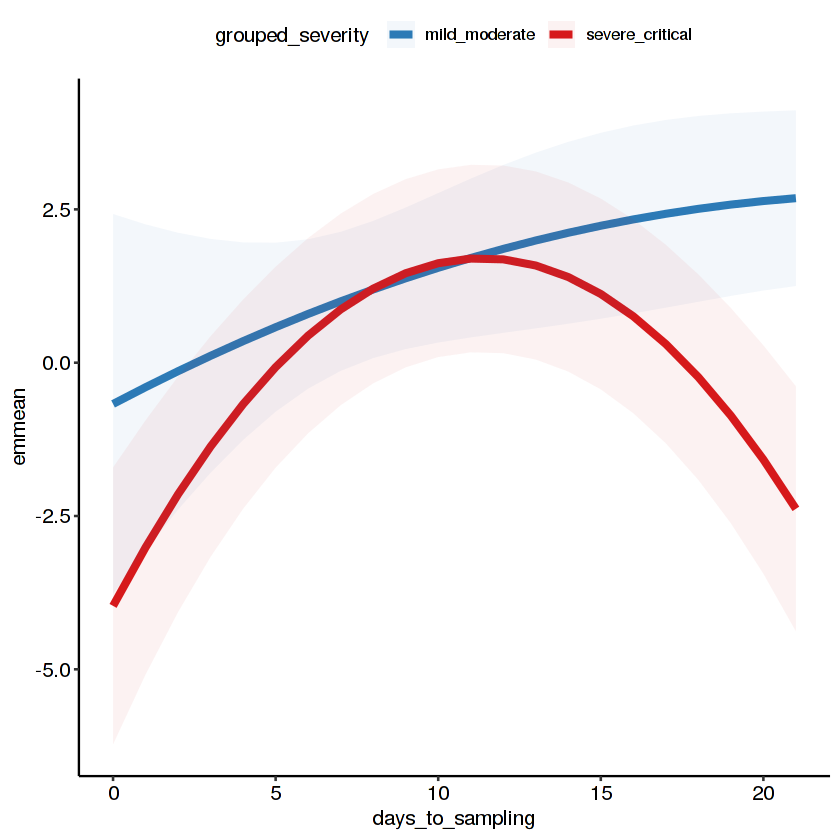

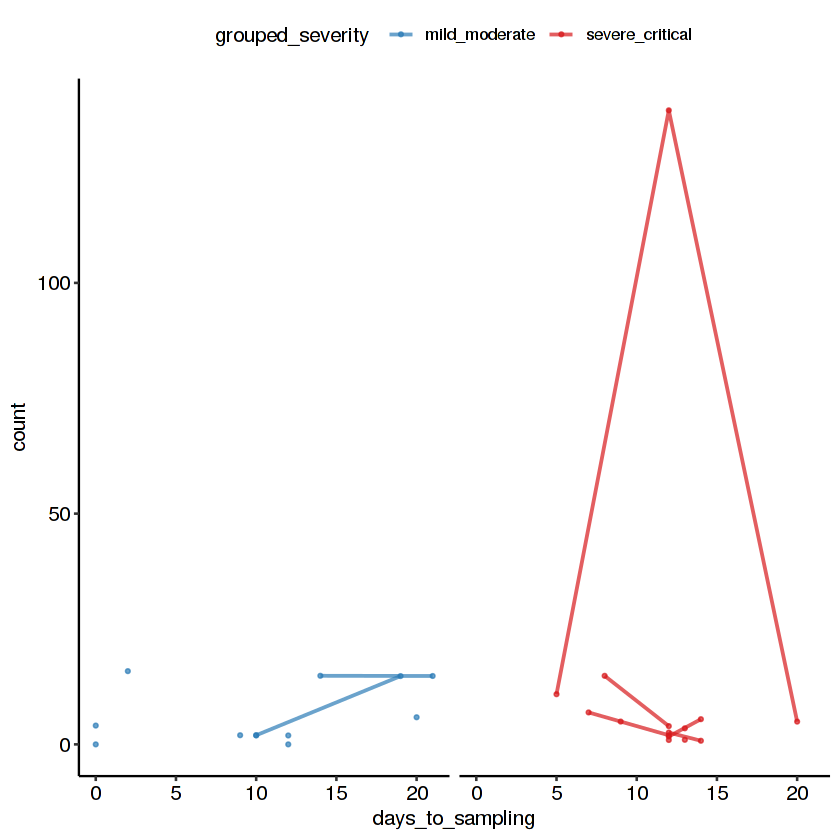

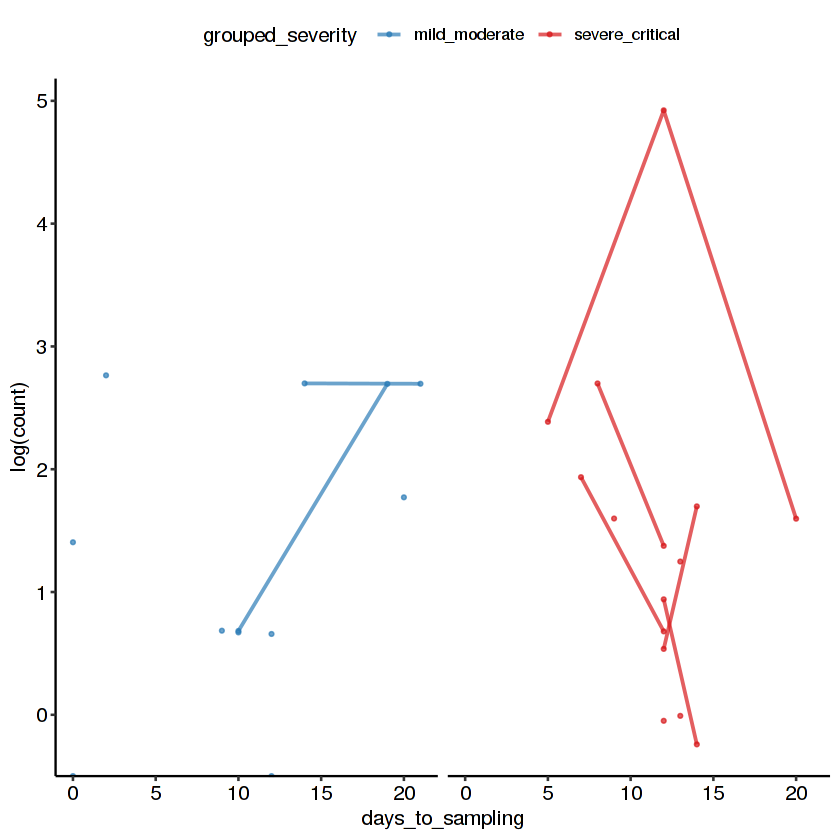

In [13]:
x = emmeans(fit, ~ days_to_sampling | grouped_severity, at = list(days_to_sampling = 0:21))

library(ggplot2)
library(ggpubr)

theme_set(theme_pubr())

ggplot(data.frame(x), aes(days_to_sampling, emmean, group = grouped_severity, fill = grouped_severity)) +
    geom_line(aes(colour = grouped_severity), size = 1.7) +
    geom_ribbon(aes(ymin = asymp.LCL, ymax = asymp.UCL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

ggplot(data, aes(days_to_sampling, count, col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

ggplot(data, aes(days_to_sampling, log(count), col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

In [29]:
emmeans(fit, specs = c("int_2"))

 int_2 emmean    SE  df asymp.LCL asymp.UCL
 0.186   1.47 0.621 Inf      0.25      2.68

Results are averaged over the levels of: grouped_severitysevere_critical, sex, ethnicity, centre 
Results are given on the log (not the response) scale. 
Confidence level used: 0.95 

In [32]:
predict(fit)

C101_180121 C101_200121   C123_2404   C123_2904   C124_2404   C128_0405 
 0.57263693  0.47734668  0.99155448  1.89472147  0.63292790  2.38752889 
  C128_1105   C132_0205   C132_1105 C138_020221 C141_260121 C147_260121 
 2.92356441  1.30318496  2.43897942 -0.44668990  1.21633647  1.34872473 
C147_280121 C170_020221 C187_230121 C190_010221    C20_1004    C20_1404 
 1.12423336 -2.87820037  0.59201075  1.07480490  2.03977553  2.38682651 
   C21_1004    C21_1704    C21_2504    C23_2204  C33_260121    C36_1504 
 2.89910283  4.66526757  1.41581280  1.78153526  0.02745494  1.05214347 
   C42_1504    C60_2504    C65_1704 
 2.80702783  1.14101727  1.87943471

In [190]:
library(ggeffects)

In [30]:
longt_anova <- cbind(data.frame(anova(fit)),data.frame(car::Anova(fit)))
longt_anova

,npar,Sum.Sq,Mean.Sq,F.value,Chisq,Df,Pr..Chisq.
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
time_1,1,3.0676924,3.0676924,3.0676924,1.19493671,1,0.27433602
time_2,1,5.0601928,5.0601928,5.0601928,3.09897647,1,0.07834153
grouped_severitysevere_critical,1,0.5107818,0.5107818,0.5107818,4.18196512,1,0.04085630
int_1,1,42.6214238,42.6214238,42.6214238,6.11062526,1,0.01343716
int_2,1,0.6699020,0.6699020,0.6699020,0.72745144,1,0.39371052
sex,1,0.4699251,0.4699251,0.4699251,0.07713939,1,0.78121211
ethnicity,3,7.5022338,2.5007446,2.5007446,4.77909783,3,0.18870598
age_scaled,1,3.3432012,3.3432012,3.3432012,3.11360062,1,0.07764114
centre,1,3.1882570,3.1882570,3.1882570,3.18744628,1,0.07420585


In [247]:
# reducedVars <- rownames(attr(terms(modelFormula), "factors"))
reducedVars <- c('grouped_severity', 'sex', 'ethnicity', 'scale(calc_age)','centre')

In [248]:
varLevels <- lapply(reducedVars, function(x) {
      if (is.factor(metadata[, x])) {
        return(levels(metadata[, x]))
      } else {sort(unique(metadata[, x]))}
    })
modelData <- expand.grid(varLevels)
modelData

ERROR: Error in `[.data.frame`(metadata, , x): undefined columns selected


In [23]:
faminfo <- insight::model_info(fit)

ERROR: Error in insight::model_info(fit): object 'fit' not found


In [234]:
levels(designMatrix[, x])

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'levels': object 'x' not found


In [24]:
# modelData

In [25]:
# designMatrix

In [26]:
fit

ERROR: Error in eval(expr, envir, enclos): object 'fit' not found


In [212]:
predictions <- ggemmeans(fit)

ERROR: Error in `[.data.frame`(md, , needed.vars, drop = FALSE): undefined columns selected


In [221]:
data(efc)
fit2 <- lm(barthtot ~ c12hour + neg_c_7, data = efc)

ggemmeans(fit2, terms = "c12hour")

x,predicted,std.error,conf.low,conf.high,group
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,75.07243,1.0766338,72.95933,77.18553,1
5,73.84301,1.0240953,71.83302,75.85299,1
10,72.61358,0.9758897,70.69821,74.52895,1
15,71.38416,0.9326891,69.55358,73.21474,1
20,70.15474,0.8952182,68.39770,71.91178,1
25,68.92532,0.8642228,67.22911,70.62152,1
30,67.69590,0.8404196,66.04641,69.34538,1
35,66.46647,0.8244319,64.84837,68.08458,1
40,65.23705,0.8167186,63.63408,66.84002,1


In [223]:
efc

c12hour,e15relat,e16sex,e17age,e42dep,c82cop1,c83cop2,c84cop3,c85cop4,c86cop5,⋯,barthtot,neg_c_7,pos_v_4,quol_5,resttotn,tot_sc_e,n4pstu,nur_pst,grp,negc7d
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
16,2,2,83,3,3,2,2,2,1,⋯,75,12,12,14,0,4,0,NA,child,1
148,2,2,88,3,3,3,3,3,4,⋯,75,20,11,10,4,0,0,NA,child,1
70,1,2,82,3,2,2,1,4,1,⋯,35,11,13,7,0,1,2,2,spouse/partner,0
168,1,2,67,4,4,1,3,1,1,⋯,0,10,15,12,2,0,3,3,spouse/partner,0
168,2,2,84,4,3,2,1,2,2,⋯,25,12,15,19,2,1,2,2,child,1
16,2,2,85,4,2,2,3,3,3,⋯,60,19,9,8,1,3,2,2,child,1
161,1,1,74,4,4,2,4,1,1,⋯,5,15,13,20,0,0,3,3,spouse/partner,1
110,4,2,87,4,3,2,2,1,1,⋯,35,11,14,20,0,1,1,1,daughter or son -in-law,0
28,2,2,79,4,3,2,3,2,2,⋯,15,15,13,8,0,2,3,3,child,1


In [225]:
fit

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Negative Binomial(29.248)  ( log )
Formula: 
count ~ splines::bs(days_to_sampling, degree = 2) + grouped_severity +  
    sex + ethnicity + scale(calc_age) + centre + (1 | individual_id) +  
    splines::bs(days_to_sampling, degree = 2):grouped_severity
   Data: data
 Offset: offset
     AIC      BIC   logLik deviance df.resid 
190.4709 208.6126 -81.2354 162.4709       13 
Random effects:
 Groups        Name        Std.Dev.
 individual_id (Intercept) 0.8325  
Number of obs: 27, groups:  individual_id, 19
Fixed Effects:
                                                               (Intercept)  
                                                                  -2.29075  
                                splines::bs(days_to_sampling, degree = 2)1  
                                                                   2.92559  
                                splines::bs(days_to_sampling, de

In [220]:
predictions <- ggemmeans(fit, terms = "splines::bs(days_to_sampling, degree = 2):grouped_severity")

ERROR: Error in `[.data.frame`(md, , needed.vars, drop = FALSE): undefined columns selected


In [203]:
insight::get_data(fit, effects = 'all')

ERROR: Error in `[.data.frame`(md, , needed.vars, drop = FALSE): undefined columns selected


In [196]:
longt_results <- rbind(longt_anova, data.frame(
            module = 'gene',
            inter_p = longt_anova$Pr..Chisq.[7],
            time_p = longt_anova$Pr..Chisq.[1],
            sev_p = longt_anova$Pr..Chisq.[2],
            sev_beta = data.frame(summary(fit)$coefficients)$Estimate[4],
            wave_p = longt_anova$Pr..F.[6],
            wave_beta = data.frame(summary(fit)$coefficients)$Estimate[10]
        ))

ERROR: Error in data.frame(module = "gene", inter_p = longt_anova$Pr..Chisq.[7], : arguments imply differing number of rows: 1, 0


In [191]:
predictions <- ggemmeans(fit)

Loading required namespace: emmeans



ERROR: Error: Package `emmeans` required to compute marginal effects with `ggemmeans()`.


In [163]:
metap::sumlog(c(0.01304820, 0.39744248))

chisq =  10.52362  with df =  4  p =  0.03247318 

In [164]:
metap::sumz(c(0.01304820, 0.39744248))

sumz =  1.756981 p =  0.0394605 

In [60]:
lmerTest::as_lmerModLmerTest(fit)

ERROR: Error in lmerTest::as_lmerModLmerTest(fit): model not of class 'lmerMod': cannot coerce to class 'lmerModLmerTest


In [168]:
summary(fit)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Negative Binomial(29.248)  ( log )
Formula: 
count ~ splines::bs(days_to_sampling, degree = 2) + grouped_severity +  
    sex + ethnicity + calc_age + centre + (1 | individual_id) +  
    splines::bs(days_to_sampling, degree = 2):grouped_severity
   Data: data
 Offset: offset
Control: control

     AIC      BIC   logLik deviance df.resid 
   190.5    208.6    -81.2    162.5       13 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.79161 -0.73923 -0.07422  0.60582  2.46513 

Random effects:
 Groups        Name        Variance Std.Dev.
 individual_id (Intercept) 0.6924   0.8321  
Number of obs: 27, groups:  individual_id, 19

Fixed effects:
                                                                           Estimate
(Intercept)                                                                 1.67023
splines::bs(days_to_sampling, degree = 2)1                   

In [167]:
fit

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Negative Binomial(29.248)  ( log )
Formula: 
count ~ splines::bs(days_to_sampling, degree = 2) + grouped_severity +  
    sex + ethnicity + calc_age + centre + (1 | individual_id) +  
    splines::bs(days_to_sampling, degree = 2):grouped_severity
   Data: data
 Offset: offset
     AIC      BIC   logLik deviance df.resid 
190.4710 208.6127 -81.2355 162.4710       13 
Random effects:
 Groups        Name        Std.Dev.
 individual_id (Intercept) 0.8321  
Number of obs: 27, groups:  individual_id, 19
Fixed Effects:
                                                               (Intercept)  
                                                                   1.67023  
                                splines::bs(days_to_sampling, degree = 2)1  
                                                                   2.90425  
                                splines::bs(days_to_sampling, degree = 

In [70]:
car::Anova(fit, type = 3)

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
(Intercept),0.76656707,1,3.812812e-01
"splines::bs(days_to_sampling, degree = 2)",6.21063178,2,4.481036e-02
grouped_severity,4.22201005,1,3.990286e-02
sex,0.07642318,1,7.822044e-01
ethnicity,4.76696667,3,1.896782e-01
calc_age,3.10478964,1,7.806232e-02
centre,3.20043565,1,7.361866e-02
"splines::bs(days_to_sampling, degree = 2):grouped_severity",38.77572779,2,3.801524e-09


Computing profile confidence intervals ...



In [29]:
test

$stats
                                                                Dispersion 
                                                              3.419036e-02 
                                                                       AIC 
                                                              1.904710e+02 
                                                                    logLik 
                                                             -8.123548e+01 
                                                               (Intercept) 
                                                              1.670228e+00 
                                splines::bs(days_to_sampling, degree = 2)1 
                                                              2.904249e+00 
                                splines::bs(days_to_sampling, degree = 2)2 
                                                              3.340376e+00 
                                           grouped_severitysevere_critical 
     

In [30]:
generics::tidy(anova(test$fit, ddf="Satterthwaite", type=3))

term,npar,sumsq,meansq,statistic
<chr>,<int>,<dbl>,<dbl>,<dbl>
"splines::bs(days_to_sampling, degree = 2)",2,8.1205937,4.0602969,4.0602969
grouped_severity,1,0.5109861,0.5109861,0.5109861
sex,1,0.8547432,0.8547432,0.8547432
ethnicity,3,11.8845165,3.9615055,3.9615055
calc_age,1,3.0330279,3.0330279,3.0330279
centre,1,4.7035553,4.7035553,4.7035553
"splines::bs(days_to_sampling, degree = 2):grouped_severity",2,37.3371846,18.6685923,18.6685923


In [98]:
glmerModLmerTest <-
  setClass("glmerModLmerTest",
           contains = c("glmerMod"),
           representation = representation(vcov_varpar = "matrix",
                                           Jac_list = "list",
                                           vcov_beta = "matrix",
                                           sigma = "numeric"))

In [157]:
fit2 <- as_glmerModLmerTest(fit)

In [158]:
single_anova(fit2)

In [71]:
show_tests(anova(test$fit))

ERROR: Error in show_tests.default(anova(test$fit)): 'object' does not have an 'hypotheses' attribute


In [131]:
  model <- fit
  mc <- getCall(model)
  args <- c(as.list(mc), devFunOnly=TRUE)
  Call <- as.call(c(list(quote(lme4::glmer)), args[-1]))
  ff <- environment(formula(model))
  pf <- parent.frame()  ## save parent frame in case we need it
  sf <- sys.frames()[[1]]
  ff2 <- environment(model)
  devfun <- tryCatch(eval(Call, envir=pf),
                     error=function(e) {
                       tryCatch(eval(Call, envir=ff),
                                error=function(e) {
                                  tryCatch(eval(Call, envir=ff2),
                                           error=function(e) {
                                             tryCatch(eval(Call, envir=sf),
                                                      error=function(e) {
                                                        "error" })})})})

In [132]:
if((is.character(devfun) && devfun == "error") || !is.function(devfun))
    stop("Unable to extract deviance function from model fit")

In [133]:
as_glmerModLT(model, devfun, tol=tol)

ERROR: Error in as(model, "lmerModLmerTest"): no method or default for coercing “glmerMod” to “lmerModLmerTest”


In [128]:
Call

lme4::lmer(formula = count ~ splines::bs(days_to_sampling, degree = 2) + 
    grouped_severity + sex + ethnicity + calc_age + centre + 
    (1 | individual_id) + splines::bs(days_to_sampling, degree = 2):grouped_severity, 
    data = data, family = MASS::negative.binomial(theta = 1/fullList[[1]]$dispersion), 
    control = control, offset = offset, devFunOnly = FALSE)

In [121]:
devfun

function (pars) 
{
    resp$setOffset(baseOffset)
    resp$updateMu(lp0)
    pp$setTheta(as.double(pars[dpars]))
    spars <- as.numeric(pars[-dpars])
    offset <- if (length(spars) == 0) 
        baseOffset
    else baseOffset + pp$X %*% spars
    resp$setOffset(offset)
    p <- pwrssUpdate(pp, resp, tol = tolPwrss, GQmat = GQmat, 
        compDev = compDev, grpFac = fac, maxit = maxit, verbose = verbose)
    resp$updateWts()
    p
}
<environment: 0x5609bf1d6fb0>

In [33]:
# Comparison 3: just wave 1, deg from positive vs negative
sce2 <- sce[, sce$centre == 'NCL']
# Remove samples with less than MIN
nCells <- table(sce2$sample_id)
rmSamples <- names(nCells[nCells<5])
sce1 <- sce2[,!sce2$sample_id %in% rmSamples]
# drop unused levels
sce1$individual_id <- droplevels(sce1$individual_id)
sce1$sample_id <- droplevels(sce1$sample_id)
sce1$case_control <- droplevels(sce1$case_control)
sce1$ethnicity <- droplevels(sce1$ethnicity)
sce1$sex <- droplevels(sce1$sex)
# Summarize Counts
smrzd <- aggregateAcrossCells(sce1, id=as.character(colData(sce1)[,c("sample_id")]))
y <- DGEList(counts=counts(smrzd), samples=colData(smrzd))
y <- setupDGElist(y, 'case_control')

In [ ]:
res2 <- testDGElist(y, 
            formula = as.formula("~ case_control + sex + ethnicity + calc_age + (1|individual_id)"), 
            individual_id = 'individual_id',
            designMatrix = model.matrix(as.formula("~ case_control + sex + ethnicity + calc_age"), data=y$samples)
           )

In [9]:
# Comparison 4: just patients that were negative in wave 1 but positive in wave 2, deg from recovery vs negative
sce2 <- sce[, sce$individual_id %in% c('C101', 'C108', 'C137', 'C138', 'C140', 'C141', 'C145', 'C146', 'C147', 'C168', 'C169', 'C170', 'C187', 'C190', 'C33')]
# Remove samples with less than MIN
nCells <- table(sce2$sample_id)
rmSamples <- names(nCells[nCells<5])
sce3 <- sce2[,!sce2$sample_id %in% rmSamples]
# remove non-complete data (all have positive), 1 = negative, 3 = recovery
df = table(sce3$individual_id, sce3$case_control)
keep_ids = row.names(df)[which(df[,1] != 0 & df[,3] != 0)]
sce1 <- sce3[, sce3$individual_id %in% keep_ids]
# drop unused levels
sce1$individual_id <- droplevels(sce1$individual_id)
sce1$sample_id <- droplevels(sce1$sample_id)
sce1$case_control <- droplevels(sce1$case_control)
sce1$ethnicity <- droplevels(sce1$ethnicity)
sce1$sex <- droplevels(sce1$sex)
# Summarize Counts
smrzd <- aggregateAcrossCells(sce1, id=as.character(colData(sce1)[,c("sample_id")]))
y <- DGEList(counts=counts(smrzd), samples=colData(smrzd))
y <- setupDGElist(y, 'case_control', remove = 'POSITIVE')

In [12]:
res2 <- testDGElist(y, 
            formula = as.formula("~ case_control + sex + ethnicity + calc_age + (1|individual_id)"), 
            individual_id = 'individual_id'
           )


n = 16 samples, 8 individuals
Time difference of 1.628746 mins


In [10]:
model.matrix(as.formula("~ case_control + sex + ethnicity + calc_age"), data = y$samples)

,(Intercept),case_controlPOSITIVE,sexM,ethnicityblack,ethnicityother,ethnicitywhite,calc_age
C101_180121,1,1,1,0,0,0,61
C101_200121,1,1,1,0,0,0,61
C123_2404,1,1,1,0,0,0,66
C123_2904,1,1,1,0,0,0,66
C124_2404,1,1,1,0,0,0,81
C128_0405,1,1,1,0,0,0,72
C128_1105,1,1,1,0,0,0,72
C132_0205,1,1,0,0,0,0,77
C132_1105,1,1,0,0,0,0,77
C138_020221,1,1,0,0,0,0,77
